In [89]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from collections import Counter

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings('ignore')

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [90]:
traindf = pd.read_csv("../input/train.csv")
testdf  = pd.read_csv("../input/test.csv")
Ids = testdf.PassengerId

In [91]:
target = traindf['Survived']
all_data = [traindf,testdf]

made a list of two data sets

Outlier Detection

In [92]:
numerical_features = [col for col in traindf.drop("PassengerId",axis=1)._get_numeric_data().columns ]
catg_cols = traindf.select_dtypes(include=["object"]).columns.values

In [93]:
outlier_indices=[]
indices =[]
for col in numerical_features:
    q1,q3 = np.percentile(traindf[col],[25,75])
    IQR = q3-q1
    upper_bound = q3+1.5*IQR
    lower_bound = q1-1.5*IQR
    data = traindf[(traindf[col]>upper_bound)] | traindf[traindf[col]<lower_bound]
    outlier_indices.extend(data.index)
outlier_indices = Counter(outlier_indices)
outlier_indices = [k for k,v in outlier_indices.items() if v>2]
outlier_indices
traindf.loc[outlier_indices]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [94]:
traindf = traindf.drop(outlier_indices,axis=0).reset_index(drop=True)
target = target.drop(outlier_indices,axis=0).reset_index(drop=True)

**Survial**

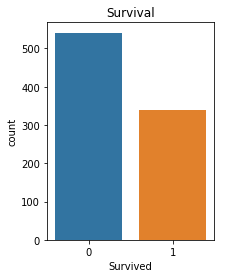

,person_survived,person not survived
survival(%),38.59,61.41


In [95]:
portion_survived   = (traindf[traindf['Survived']==1]["Survived"].count()/traindf.shape[0])*100
portion_not_survived = (traindf[traindf['Survived']==0]["Survived"].count()/traindf.shape[0])*100
fig = plt.figure(figsize=(3,4))
sns.countplot(traindf['Survived'])
plt.title("Survival")
plt.show()
survival_df  =pd.DataFrame({"person_survived":"%0.2f"%portion_survived,"person not survived":"%0.2f"%portion_not_survived},index=["survival(%)"])
survival_df

these digits are based on train data set

**Sex**

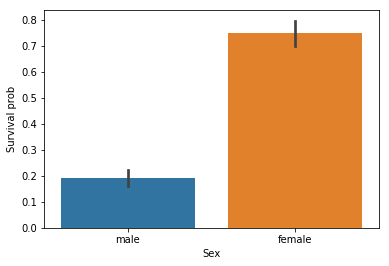

,Survived
Sex,
female,0.747573
male,0.190559


In [96]:
plt.figure(figsize=(6,4))
sns.barplot(traindf["Sex"],y=traindf["Survived"])
plt.ylabel("Survival prob")
plt.show()
traindf[["Sex","Survived"]].groupby("Sex").mean()

as we can see survival rate of female is much higher than male, it is obvious!  

**Pclass**

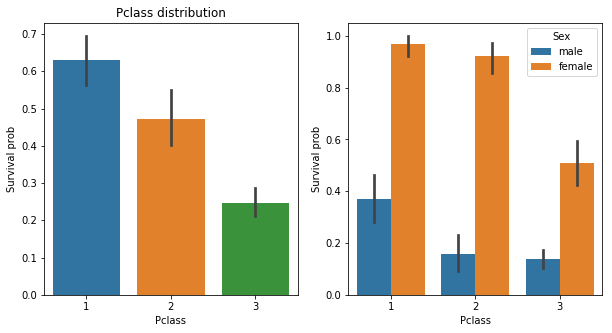

,Survival(%),Total_passenger
classp1,62.910798,213
classp2,47.282609,184
classp3,24.586777,484


In [97]:
classp1_pass = (traindf[traindf["Pclass"]==1].reset_index(drop=True))
classp2_pass = (traindf[traindf["Pclass"]==2].reset_index(drop=True))
classp3_pass= (traindf[traindf["Pclass"]==3].reset_index(drop=True))
proportion_p1 = (classp1_pass[classp1_pass["Survived"]==1]["Survived"].count()/len(classp1_pass))*100
proportion_p2 = (classp2_pass[classp2_pass["Survived"]==1]["Survived"].count()/len(classp2_pass))*100
proportion_p3 = (classp3_pass[classp3_pass["Survived"]==1]["Survived"].count()/len(classp3_pass))*100
survivalC = pd.DataFrame({"Survival(%)":[proportion_p1,proportion_p2,proportion_p3],"Total_passenger":[len(classp1_pass),len(classp2_pass),len(classp3_pass)]},index=["classp1","classp2","classp3"])
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x='Pclass',y='Survived',data=traindf,ax=ax[0])
sns.barplot(x='Pclass',y='Survived',hue="Sex",data=traindf,ax=ax[1])
ax[0].set_title("Pclass distribution")
ax[0].set_ylabel("Survival prob")
ax[1].set_ylabel("Survival prob")
plt.show()
survivalC


1st figure shows the survival rate according to their socio-economic status, upper class has higher survival rate. In 2nd figure it is clear what we have seen before, survival rate of female in all the classes has higher than male

In [98]:
for data in [traindf,testdf]:
    data["Sex"] = data["Sex"].apply(lambda x: 1 if x=="male" else 0)
    data["Pclass"] = data["Pclass"].astype(str)

**SibSp and Parch**

In [99]:
for data in [traindf,testdf]:
    data["total_members"] = data["SibSp"]+data["Parch"]+1
    data['isAlone'] = data["total_members"].apply(lambda x: 1 if x==1 else 0)

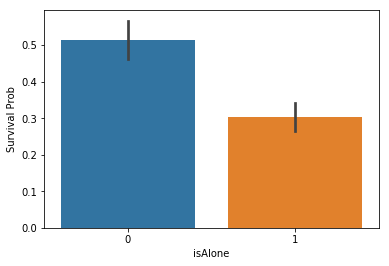

In [100]:
plt.figure()
sns.barplot(x = traindf["isAlone"],y=traindf["Survived"])
plt.ylabel("Survival Prob")
plt.show()


the figure shows that survival rate of people who were traveling with their families has higher survival rate than traveling alone.

**Age**

In [101]:
print(traindf["Age"].describe())
print("----------------------------")
print(testdf["Age"].describe())

count    711.000000
mean      29.731603
std       14.547835
min        0.420000
25%       20.250000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
----------------------------
count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64


in both data set there are missing values therfore we should fill these missing values according to the age distribution

Age    29.87763
Name: 2, dtype: float64

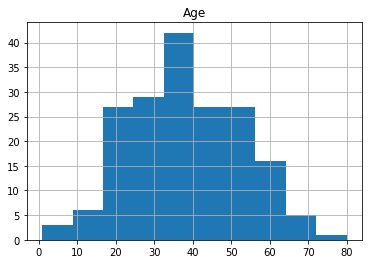

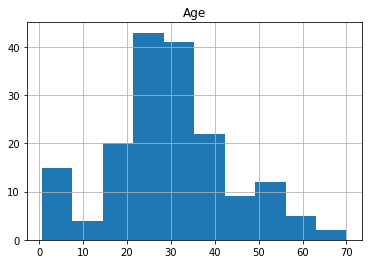

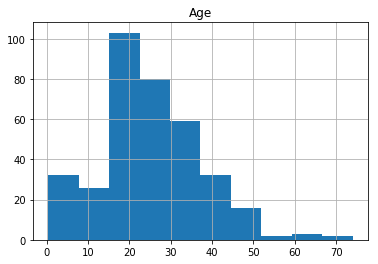

In [102]:
traindf[["Pclass","Age"]].groupby("Pclass").hist()
traindf[["Pclass","Age"]].groupby("Pclass").mean().iloc[1]

In [103]:
import random
for data in [traindf,testdf]:
    st = int(data["Age"].std())
    mean = int(data["Age"].mean())
    data["Age"] = data["Age"].fillna(random.randint(mean-st,mean+st))

<Figure size 432x288 with 0 Axes>

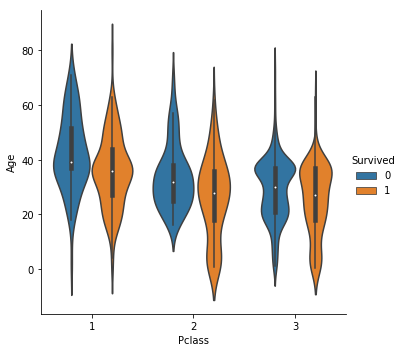

<Figure size 432x288 with 0 Axes>

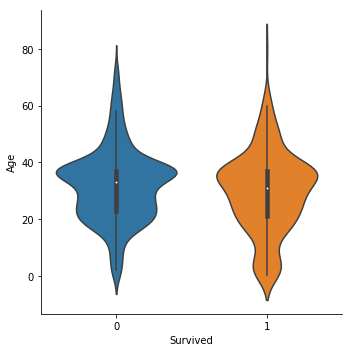

In [104]:
plt.figure()
sns.catplot(x='Pclass',y="Age",hue="Survived",data=traindf,kind='violin')
plt.show()
plt.figure()
sns.catplot(x='Survived',y='Age',data=traindf,kind="violin")
plt.show()

In [105]:
for data in [traindf,testdf]:
    data["Age"] = data["Age"].apply(lambda x:"1" if x<=10 else("2" if (x>10 and x<30) else "3"))

In [106]:
traindf["Age"].sample(2)

362    2
824    3
Name: Age, dtype: object

**Embarked**

In [107]:
for data in [traindf,testdf]:
    data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode())

In [108]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 14 columns):
PassengerId      881 non-null int64
Survived         881 non-null int64
Pclass           881 non-null object
Name             881 non-null object
Sex              881 non-null int64
Age              881 non-null object
SibSp            881 non-null int64
Parch            881 non-null int64
Ticket           881 non-null object
Fare             881 non-null float64
Cabin            201 non-null object
Embarked         879 non-null object
total_members    881 non-null int64
isAlone          881 non-null int64
dtypes: float64(1), int64(7), object(6)
memory usage: 96.4+ KB


In [109]:
traindf.describe()

,PassengerId,Survived,Sex,SibSp,Parch,Fare,total_members,isAlone
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,0.649262,0.455165,0.363224,31.121566,1.818388,0.609535
std,256.617021,0.487090,0.477472,0.871571,0.791839,47.996249,1.382086,0.488132
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,226.000000,0.000000,0.000000,0.000000,0.000000,7.895800,1.000000,0.000000
50%,448.000000,0.000000,1.000000,0.000000,0.000000,14.454200,1.000000,1.000000
75%,668.000000,1.000000,1.000000,1.000000,0.000000,30.500000,2.000000,1.000000
max,891.000000,1.000000,1.000000,5.000000,6.000000,512.329200,8.000000,1.000000


<Figure size 1800x432 with 0 Axes>

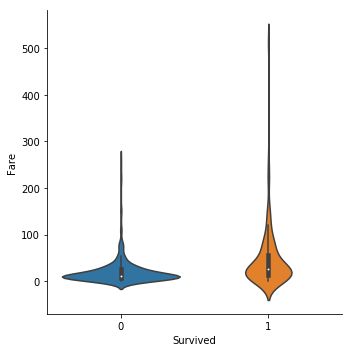

In [110]:
plt.figure(figsize=(25,6))
sns.catplot(x="Survived",y="Fare",data=traindf,kind='violin')

In [111]:
for data in [traindf,testdf]:
    median = data["Fare"].median()
    bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 50),(50,1000)],closed="left")
    data["Fare"] = data["Fare"].fillna(median)
    data["Fare"] = pd.cut(data["Fare"],bins,labels=[1,2,3])
    

In [112]:
traindf.describe()

,PassengerId,Survived,Sex,SibSp,Parch,total_members,isAlone
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,0.649262,0.455165,0.363224,1.818388,0.609535
std,256.617021,0.487090,0.477472,0.871571,0.791839,1.382086,0.488132
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,226.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,448.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,668.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000
max,891.000000,1.000000,1.000000,5.000000,6.000000,8.000000,1.000000


In [113]:
drop_columns = ["PassengerId","Name","SibSp","Parch","Ticket","Cabin"]

In [114]:
for data in [traindf,testdf]:
    data.drop(drop_columns,axis=1,inplace=True)

In [115]:
traindf = traindf.drop("Survived",axis=1)

In [116]:
for data in [traindf,testdf]:
    data["total_members"] = data["total_members"].astype(str)

In [117]:
data = pd.concat([traindf,testdf],axis=0)
data = pd.get_dummies(data)
traindf = data[:traindf.shape[0]]
testdf = data[traindf.shape[0]:]

In [118]:
trainX = traindf.values
trainY = target.values
testX = testdf.values
from sklearn.model_selection import train_test_split
trainx,testx,trainy,testy = train_test_split(trainX,trainY,test_size=0.3,random_state=42)

# Model performance

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


In [120]:
classifier = []
lr = LogisticRegression()
rf = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
bc = BaggingClassifier()
etc = ExtraTreesClassifier()
xgbc = XGBClassifier()
svm = SVC()
dtc = DecisionTreeClassifier()
classifier.extend([lr,abc,rf,gbc,bc,etc,xgbc,svm,dtc])

In [121]:
from sklearn.model_selection import KFold,cross_val_score,cross_validate
def scoreModel(n_cv,model):
        kf = KFold(n_cv,random_state=42,shuffle=True).get_n_splits()
        cv_score = cross_validate(model,trainX,trainY,cv=kf)
        return cv_score

In [122]:
cv_results_train=[]
cv_results_test = []
model_param = []
model_time = []
cv_std=[]
for model in classifier:
    score = scoreModel(10,model)
    model_param.append((model.get_params()))
    cv_results_train.append(score["train_score"].mean())
    cv_results_test.append(score["test_score"].mean())
    model_time.append(score["fit_time"].mean())
    cv_std.append(score["test_score"].std())

In [123]:
df = pd.DataFrame({"ML algorithms":[model.__class__.__name__ for model in classifier],"Parameters":model_param,"Accuracy mean(train)":cv_results_train,"Accuracy mean(test)":cv_results_test,
                  "fit time(sec)":model_time,"Cv_std":cv_std})
df.sort_values(by="Accuracy mean(test)",ascending=False).reset_index(drop=True)

,ML algorithms,Parameters,Accuracy mean(train),Accuracy mean(test),fit time(sec),Cv_std
0,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.837306,0.819497,0.098855,0.035849
1,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.842854,0.817237,0.096887,0.040544
2,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.810443,0.805899,0.070779,0.028516
3,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.812712,0.804775,0.004107,0.032800
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.859251,0.804763,0.013343,0.033654
5,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.860638,0.802490,0.001735,0.032259
6,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.858620,0.801417,0.018365,0.032207
7,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.860638,0.801353,0.013286,0.032286
8,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.797579,0.791126,0.029224,0.031526


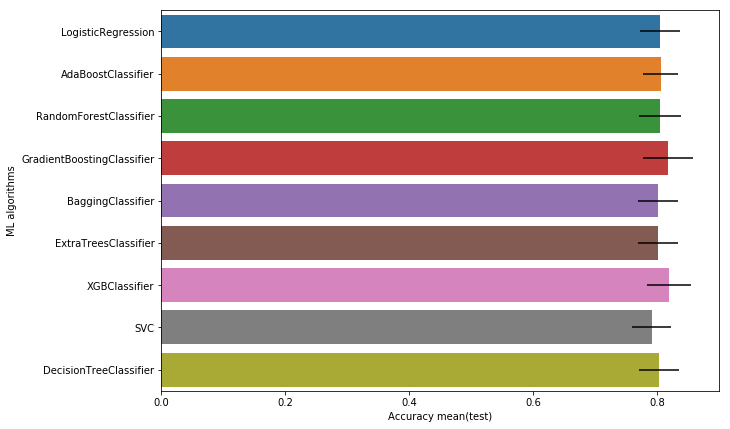

In [124]:
plt.figure(figsize=(10,7))
sns.barplot(x='Accuracy mean(test)',y="ML algorithms",data=df,orient="V",**{"xerr":cv_std})

# **HyperParamter Tuning**

In [183]:
from sklearn.model_selection import GridSearchCV
cv_split = KFold(7,random_state=42,shuffle=True).get_n_splits()
dtc_params={"criterion":["gini","entropy"], "min_samples_split":[2,3,4],"min_samples_leaf":[1,2],"random_state":[0],"max_depth":[100,200,None]}
rf_params={"criterion":["gini","entropy"],"bootstrap" :[True,False],"random_state":[0],"n_estimators":[50,100,300]}
abc_params={"n_estimators":[50,100,300],"learning_rate":[0.01,0.03,0.1,0.3,1],"algorithm":["SAMME.R"],"random_state":[0]}
gbc_params={"loss":["deviance"],"learning_rate":[0.01,0.03,0.1,0.3,1],"n_estimators":[50,300,500],"random_state":[0],"criterion":["friedman_mse"]}
bc_params={"n_estimators":[50,100,300],"oob_score":[True,False],"random_state":[0]}
xgbc_param = {"booster":["dart","gbtree"],"learning_rate":[0.1,0.3,1],"max_depth":[2,3,4],"n_estimators":[100,300],"seed":[0]}

In [184]:
gridSearch = []
gs_dtc = GridSearchCV(dtc,param_grid = dtc_params,scoring="accuracy",cv=cv_split,verbose=1,n_jobs=-1)
gs_rf = GridSearchCV(rf,param_grid=rf_params,scoring="accuracy",n_jobs=-1,cv=cv_split,verbose=1)
gs_abc = GridSearchCV(abc,param_grid=abc_params,scoring="accuracy",n_jobs=-1,cv=cv_split,verbose=1)
gs_gbc = GridSearchCV(gbc,param_grid=gbc_params,scoring="accuracy",n_jobs=-1,cv=cv_split,verbose=1)
gs_bc = GridSearchCV(bc,param_grid=bc_params,scoring="accuracy",n_jobs=-1,cv=cv_split,verbose=1)
gs_xgbc = GridSearchCV(xgbc,param_grid = xgbc_param,scoring="accuracy",n_jobs=-1,cv=cv_split,verbose=1)
gridSearch.extend([gs_dtc,gs_rf,gs_abc,gs_gbc,gs_bc,gs_xgbc])

In [185]:
best_params=[]
best_train_score = []
best_test_score = []
std_train = []
std_test = []
best_index =0 
for gs in gridSearch:
    gs.fit(trainx,trainy)
    best_params.append((gs.best_params_))
    train_score = gs.cv_results_["mean_train_score"][gs.best_index_]
    test_score = gs.cv_results_["mean_test_score"][gs.best_index_]
    best_train_score.extend([train_score])
    best_test_score.extend([test_score])
    std_train.append([gs.cv_results_['std_train_score'][gs.best_index_]])
    std_test.append(gs.cv_results_['std_test_score'][gs.best_index_])

Fitting 7 folds for each of 36 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    7.4s finished


Fitting 7 folds for each of 15 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  98 out of 105 | elapsed:    8.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   10.0s finished


Fitting 7 folds for each of 15 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 out of 105 | elapsed:    9.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 6 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 36 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:   32.3s finished


**model's performance after tuning**

In [186]:
grid_df = pd.DataFrame({"MLA":[model.estimator.__class__.__name__ for model in gridSearch],"Best_params":best_params,
                        "Best train accuracy":best_train_score,"Best Test accuracy":best_test_score,
                        "std_train":std_train,"std_test":std_test}
                      )
print("Performance of models after model tuning ")
grid_df.sort_values(by="Best Test accuracy",ascending=False).reset_index(drop=True)

Performance of models after model tuning 


,MLA,Best_params,Best train accuracy,Best Test accuracy,std_train,std_test
0,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'learning_rate':...",0.834136,0.829545,[0.00851295107930833],0.050461
1,XGBClassifier,"{'booster': 'dart', 'learning_rate': 0.1, 'max...",0.843068,0.827922,[0.007099041394833339],0.047093
2,RandomForestClassifier,"{'bootstrap': True, 'criterion': 'entropy', 'n...",0.872287,0.816558,[0.008735445588128748],0.063734
3,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.869582,0.803571,[0.008463482190053198],0.061584
4,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'learning_rate': 0.3,...",0.813310,0.801948,[0.006520527047607549],0.047981
5,BaggingClassifier,"{'n_estimators': 100, 'oob_score': True, 'rand...",0.872287,0.801948,[0.008735445588128748],0.063773


# voting classifier

In [187]:
i =0
for model in gridSearch:
    model.estimator.set_params(**best_params[i])
    i = i+1

In [188]:
from sklearn.ensemble import VotingClassifier
estimators = [
        ("GB",gbc),
        ("RF",rf),
        ("xgb",xgbc),
        ("ABC",abc)
]

In [189]:
vote_hard = VotingClassifier(estimators,voting="soft",weights=[2,1,3,1])
vot_hard_cv = cross_validate(vote_hard,trainx,trainy,cv=cv_split,scoring="accuracy")
vote_hard.fit(trainx,trainy)

VotingClassifier(estimators=[('GB', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1,...thm='SAMME.R', base_estimator=None,
          learning_rate=0.3, n_estimators=300, random_state=0))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[2, 1, 3, 1])

In [190]:
vote_hard.score(trainx,trainy)
vot_hard_cv["test_score"]

array([0.8988764 , 0.88764045, 0.80898876, 0.77272727, 0.83908046,
       0.75862069, 0.82758621])

In [193]:
gs_gbc.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.03,
 'loss': 'deviance',
 'n_estimators': 50,
 'random_state': 0}

In [196]:
g = GradientBoostingClassifier(criterion= 'friedman_mse',
 learning_rate= 0.01,
 loss='deviance',
 n_estimators=500,
 random_state= 0)

In [197]:
xgbc.fit(trainx,trainy)
g.fit(trainx,trainy)
g.score(testx,testy)

0.8150943396226416

In [179]:
xgbc.score(testx,testy)

0.7811320754716982

In [135]:
pred = g.predict(testX)

In [136]:
df_res = pd.DataFrame({"PassengerId":Ids,"Survived":pred})

In [137]:
output = df_res.to_csv("Output.csv",index=False)